<center> <h1> Freesound Audio Tagging </h1> </center>

<h1> 1. Business Problem </h1>

## 1.1 Description of the Challenge

The goal of this competition is to develop a general-purpose audio tagging system, i.e., when the algorithm is given an audio clip as input, it detects which sound(s) are present in it.

These sounds are represented as categories and there are 80 categories/labels in this competition.
For eg., given the sound clip: https://www.fesliyanstudios.com/play-mp3/2657, it can be clearly identified that it is Baby’s laughter.

However, there can be multiple sound labels in a single clip, for example, the following clip is from a restaurant during busy hours: https://www.fesliyanstudios.com/play-mp3/3381.
Here, there are a lot of distinct sounds like people talking, keys rattling, cutlery sounds, etc.
We’ve to identify all these sounds, thus, making this competition a multi-label classification task.

This task is particularly helpful to reduce human efforts in manual labeling of these sounds
because a significant amount of manual effort goes into tasks like annotating sound collections
and providing captions for non-speech events in audiovisual content. It can be used to
automatically tag video content or recognize sound events happening in real-time.

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/freesound-audio-tagging-2019
<br><br>
__Useful Links__:
- Kaggle Kernel (EDA and 1-D CNN Model): https://www.kaggle.com/maxwell110/beginner-s-guide-to-audio-data-2 <br>
- Kaggle Kernel (Featurizations): https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data
- Research paper [Audio Tagging With Noisy Labels And Minimal Supervision] for Featurizations: https://arxiv.org/pdf/1906.02975v4.pdf
- Featurization and 2-D CNN model (Implementation of the above research paper): https://github.com/DCASE-REPO/dcase2019_task2_baseline<br>
- Understanding LWLRAP Metric: https://www.kaggle.com/pkmahan/understanding-lwlrap <br>
- LWLRAP Code: https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The major challenge in this task is to **separate noise from the core sounds as most of the sounds are environmental sounds which are very similar to each other and also to noise.** The multilabel classification makes it challenging.<br><br>
2. One use case for this task can be to generate subtitles for sounds in movies. Since, subtitle generation need not happen on the fly, **we don't have strict latency constraints.**<br><br>
3. One **major constraint is to have high precision in classifying**, because, in the above use case, if the correct sound is "rustling of leaves" and the model predicts "whispering", this is not acceptable. So, we have to aim for precision while we can have a leverage on latency.<br><br>
4. Interpretability is not very important here.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

 - The clips are of variable lengths and the categories associated are like Guitar and other Musical instruments, Percussion, Water, Digestive, Respiratory sounds, Human voice, Human locomotion, Hands, Human group actions, Insect, Domestic animals, Glass, Liquid, Motor vehicle (road), Mechanisms, Doors, and a variety of Domestic sounds.<br><br>
 - These labels are for the entire clip and not at a particular duration, hence, these can be considered as weak labels.<br><br>
 - All clips are provided as uncompressed PCM 16 bit, 44.1 kHz, mono audio files.<br><br>
 - There are two training sets: Curated training set and Noisy training set<br><br>
 - In the Curated training set, there are 5000 clips in total<br><br>
 - The Noisy dataset is the larger dataset with 20,000 clips in total<br><br>
 - Each row of the train_curated.csv and train_noisy.csv files contains the following information:
     - fname: the audio file name, eg, 0006ae4e.wav
     - labels: the audio classification label(s) (ground truth). Note that the number of labels per clip can be one, eg, Bark or more, eg, "Walk_and_footsteps, Slam"

<h3> 2.1.2 Example Data point </h3>

<pre>
Sound file Name          Labels
006d7b1d.wav	         Motorcycle, Microwave_oven
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

 - In the business problem, we've to predict the label(s) of the sound clip from 80 predefined labels.
 - This falls into a **classification task** from ML perspective.
 - The input to the model will be the sound clip given to us in .wav format. We can convert the .wav file to numerical vector which represents the amplitude of the wave w.r.t. time using libraries like "librosa".
 - Once we convert the sound clip to a numerical vector xi, we can either build a RNN/LSTM/1-D CNN model using the raw time series features or we can extract features out of the raw features (some features like MFCC features were quite popular before the DL era) and then train a ML/DL model on top of it.
 - Since there can be multiple labels for a single clip, this falls into a **multilabel classification task.**
 - We can train any model using **cross entropy loss/multiclass log loss as the optimization loss.**
 - As the output of the model, we have to **predict probabilities for each of the 80 classes.**

<h3> 2.2.2 Performance Metric </h3>

The performance metric used here is <b> LWLRAP (Label weighted label ranking average precision). </b> <br>
Here's a very nice kernel explaining in detail about this metric: https://www.kaggle.com/pkmahan/understanding-lwlrap <br>
 - This metric is particularly useful in multilabel classification
 - It is calculated on the basis on relative ranking of the labels and not the actual probability scores
 - An example for calculating LWLRAP is:
    - Assume, we have a multilabel classification problem where the set of all the possible classes, S = {A, B, C}
    
    - Let's consider one example of a point p1, where the ground truth labels are {A, C}, we'll use 1 to indicate the true labels and 0 to indicate the false labels. So, the ground truth is: <br>
      A     B     C <br>
      1     0     1
      
    - Suppose our model M predicts the prob. of each label in set S as follows:
        - Prob.(A) = 0.3
        - Prob.(B) = 0.5
        - Prob.(C) = 0.2
    - If we rank the class labels in the decreasing order of prob., the ranking will be: <br>
      A        B       C <br>
      2        1       3
      
    - This means, acc. to our model M, class B has the highest prob. of being true (i.e. having a label of 1) followed by A, followed by C
    
    - For calculating LWLRAP for the above example, first we calculate the scores for each correct label (acc. to ground truth): 
        - Score(label) = Number of correct classification while reaching that label's rank/The label's rank
        - Basically, in an ideal situation, if a label is classified to be true, all other labels having a prob. greater than it (can be also called as having a rank higher than it), should have a ground truth label of 1. Thus, we count the number of labels having a groud truth value of 1 having a rank lower than the given label's rank.
        - The correct labels acc. to ground truth are A and C, thus we've to calculate Score(A) and Score(C)
        - Score(A):->
            - Now, A's rank is 2, so while approaching rank(A) i.e. 2, we encounter rank 1 and rank 2, rank 1 is B which has a ground label of 0 and hence is incorrectly classified, rank 2 is A which has a label of 1 and is correctly classified.
            - Score(A) = (0+1)/2 = 0.5
        - Score(C): ->
            - Now, C's rank is 3, so while approaching rank(C) i.e. 3, we encounter rank 1, 2 and 3, rank 1 is B which has a ground label of 0 and hence is incorrectly classified, while rank 2 is A which has a label of 1 and is correctly classified and rank 3 is C which has a label of 1 and is correctly classified.
            - Score(C) = (0+1+1)/3 = 0.667
    - Consider another sample in the same dataset, with the ground truth as: {A, B} and predicted prob. by model M as:
        - Prob.(A) = 0.8
        - Prob.(B) = 0.05
        - Prob.(C) = 0.15
        
    - If we rank the class labels in the decreasing order of prob., the ranking will be: <br>
      A        B       C <br>
      1        3       2
      
    - We'll calculate the score of each correct ground truth label, which in this case are A and B
        - Score(A) = Number of correct classifications till A's rank/A's rank = 1/1 = 1
        - Score(B) = Number of correct classifications till B's rank/B's rank = (1+0+1)/3 = 0.667
        
    - We repeat the above activity for all the samples in the dataset and calculate the "Score" for each correct label as per ground truth of the given sample.
    
    - Now, we calculate "total score" for each correct label, which is calculated as:
        - Total Score(label) = Sum of scores of label across all samples/total number of correct samples of label
        - Here, each label A, B and C are correct in atleast one instance and hence we'll calculate the total scores for each of these
        - Total Score(A) = (Score_A_sample_1 + Score_A_sample_2)/2 = (0.5 + 1)/2 = 0.75
        - Total Score(B) = Score_B_sample_2/1 = 0.667
        - Total Score(C) = Score_C_sample_1/1 = 0.667
        
     - If we directly average these scores, it becomes Label ranking average precision (LRAP), but, the problem here is that, less frequent samples can have a high total score (suppose a sample appears only once and is correctly classified) as compared to more frequently occurring samples, to balance this we calculate the Label Weighted LRAP, i.e., we calculate the final precision not by performing simple average, but, by performing weighted average.
     
     - Weight(label) =  Number of correct label occurrence of the given label / Total number of correct labels
       The total correct label collection is: (A, A, B, C), size=4
        - Weight(A) = 2/4
        - Weight(B) = 1/4
        - Weight(C) = 1/4

     - LWLRAP = weight(A) * total_score(A) + weight(B) * total_score(B) + weight(C) * total_score(C)
              = 2/4 * 0.75 + 1/4 * 0.667 + 1/4 * 0.667
              = 0.708

 <b>The salient characterstics of this metric are:
 - Since this uses the relative ranking and not actual prob. scores, it can work with a classifier which doesn't give the calibrated prob. but a relative ranking between the prob. Also, it is not very sensitive to the prob. scores like log loss.
    
     
 - It is always strictly greater than 0 (minimum score) and is less than or equal to 1 (maximum score). The higher, the better.
     
    
 - The relative frequencies of the labels are taken into account and a weighted average is performed instead of a simple average. This results in assigning appropriate weights based on frequency of occurrence so that the less frequently appearing labels don't get undue advantage.</b>

<h2> 2.3 Train and Test Construction </h2>

<p> We have a separate test set which we'll use for final evaluation of our model. For hyperparameter tuning, we'll divide the data into train and cross validate as a 75-25 split when required </p>

## 3. Exploratory Data Analysis 

## Importing Libraries

In [1]:
# General Imports
import numpy as np
import pandas as pd
import re
import os
from tqdm import tqdm

#Statistical imports
import scipy
from scipy import stats

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

# Audio imports
import wave

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Setting the figure size for all plots: https://stackoverflow.com/questions/7125009/how-to-change-legend-size-with-matplotlib-pyplot
%matplotlib inline

params = {'figure.figsize' : (16, 8),
          'legend.fontsize': 16,
          'legend.handlelength': 2,
          'axes.titlesize' : 'large'}

plt.rcParams.update(params)

### Importing the data

In [4]:
df_train_curated = pd.read_csv(r'../train_curated.csv')
df_train_noisy = pd.read_csv(r'../train_noisy.csv')

### Preprocessing of labels: converting to lower case

In [5]:
df_train_curated['labels'] = df_train_curated['labels'].str.lower()
df_train_noisy['labels'] = df_train_noisy['labels'].str.lower()

### Basic Statistics

In [6]:
print("Number of samples in Curated training dataset = ", df_train_curated.shape[0])
print("Number of samples in Noisy training dataset = ", df_train_noisy.shape[0])

Number of samples in Curated training dataset =  4970
Number of samples in Noisy training dataset =  19815


In [7]:
df_train_curated.head(10)

,fname,labels
0,0006ae4e.wav,bark
1,0019ef41.wav,raindrop
2,001ec0ad.wav,finger_snapping
3,0026c7cb.wav,run
4,0026f116.wav,finger_snapping
5,003be5db.wav,whispering
6,0041de6b.wav,"acoustic_guitar,strum"
7,004ca909.wav,hi-hat
8,00713ec2.wav,bass_drum
9,0073825a.wav,"crowd,cheering"


In [8]:
df_train_noisy.head(10)

,fname,labels
0,00097e21.wav,bathtub_(filling_or_washing)
1,000b6cfb.wav,motorcycle
2,00116cd2.wav,"marimba_and_xylophone,glockenspiel"
3,00127d14.wav,"water_tap_and_faucet,sink_(filling_or_washing)"
4,0019adae.wav,raindrop
5,001b819d.wav,bass_guitar
6,001c054e.wav,"raindrop,trickle_and_dribble"
7,001ceaf1.wav,"strum,acoustic_guitar"
8,001f3501.wav,"bass_drum,hi-hat"
9,0020becb.wav,harmonica


# EDA on target variable: Labels

## 1. Number of clips for each label (check if dataset is balanced or not)

### 1.1 Curated Dataset

In [9]:
curated_label_list = [label.split(',') for label in list(df_train_curated['labels'])]

### Obtaining the count of each label

In [10]:
curated_dict = {}

In [11]:
for row in curated_label_list:
    for label in row:
        if label in curated_dict:
            curated_dict[label]+=1
        else:
            curated_dict[label]=1

In [12]:
print("Total number of labels in curated dataset) = ", len(curated_dict))

Total number of labels in curated dataset) =  80


In [15]:
#Sort dictionary by values: https://stackoverflow.com/a/2258273
curated_dict = sorted(curated_dict.items(), key=lambda x: x[1])
df_curated_label = pd.DataFrame(curated_dict, columns=["Label", "Count"])
df_curated_label['Count'].describe()

count    80.000000
mean     71.900000
std       7.460614
min      47.000000
25%      75.000000
50%      75.000000
75%      75.000000
max      75.000000
Name: Count, dtype: float64

### Bar plot of labels in the curated dataset

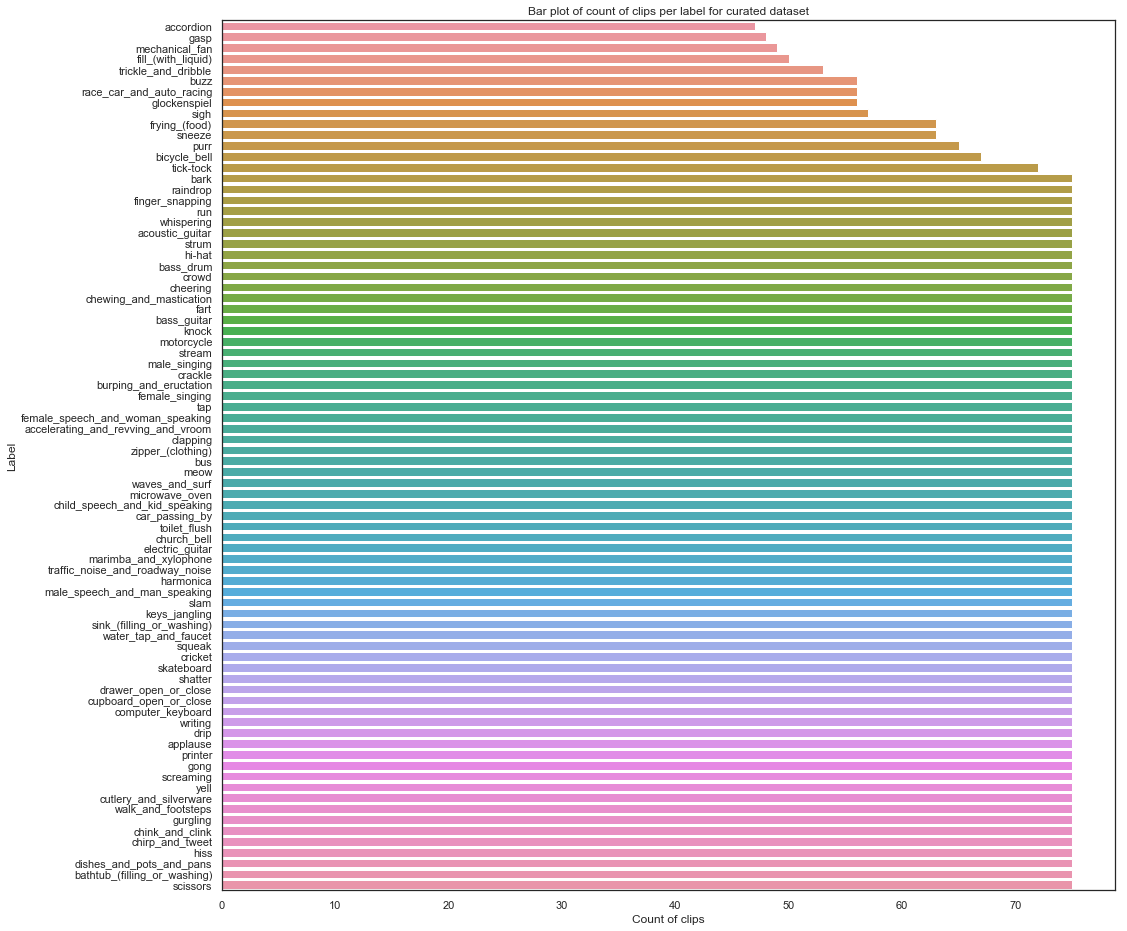

In [20]:
sns.barplot(x='Count', y='Label', data=df_curated_label)
plt.title('Bar plot of count of clips per label for curated dataset')
plt.xlabel('Count of clips')
plt.show()

### Conclusion
There are almost equal number of clips for each label in the curated dataset. This indicates the dataset is well balanced which will be useful in model building.

### 1.2 Noisy Dataset

In [21]:
noisy_label_list = [label.split(',') for label in list(df_train_noisy['labels'])]

### Obtaining the count of each label

In [22]:
noisy_dict = {}

In [23]:
for row in noisy_label_list:
    for label in row:
        if label in noisy_dict:
            noisy_dict[label]+=1
        else:
            noisy_dict[label]=1

In [24]:
print("Total number of labels in noisy dataset) = ", len(noisy_dict))

Total number of labels in noisy dataset) =  80


In [27]:
#Sort dictionary by values: https://stackoverflow.com/a/2258273
noisy_dict = sorted(noisy_dict.items(), key=lambda x: x[1])
df_noisy_label = pd.DataFrame(noisy_dict, columns=["Label", "Count"])
df_noisy_label['Count'].describe()

count     80.0
mean     300.0
std        0.0
min      300.0
25%      300.0
50%      300.0
75%      300.0
max      300.0
Name: Count, dtype: float64

### Bar plot of labels in the noisy dataset

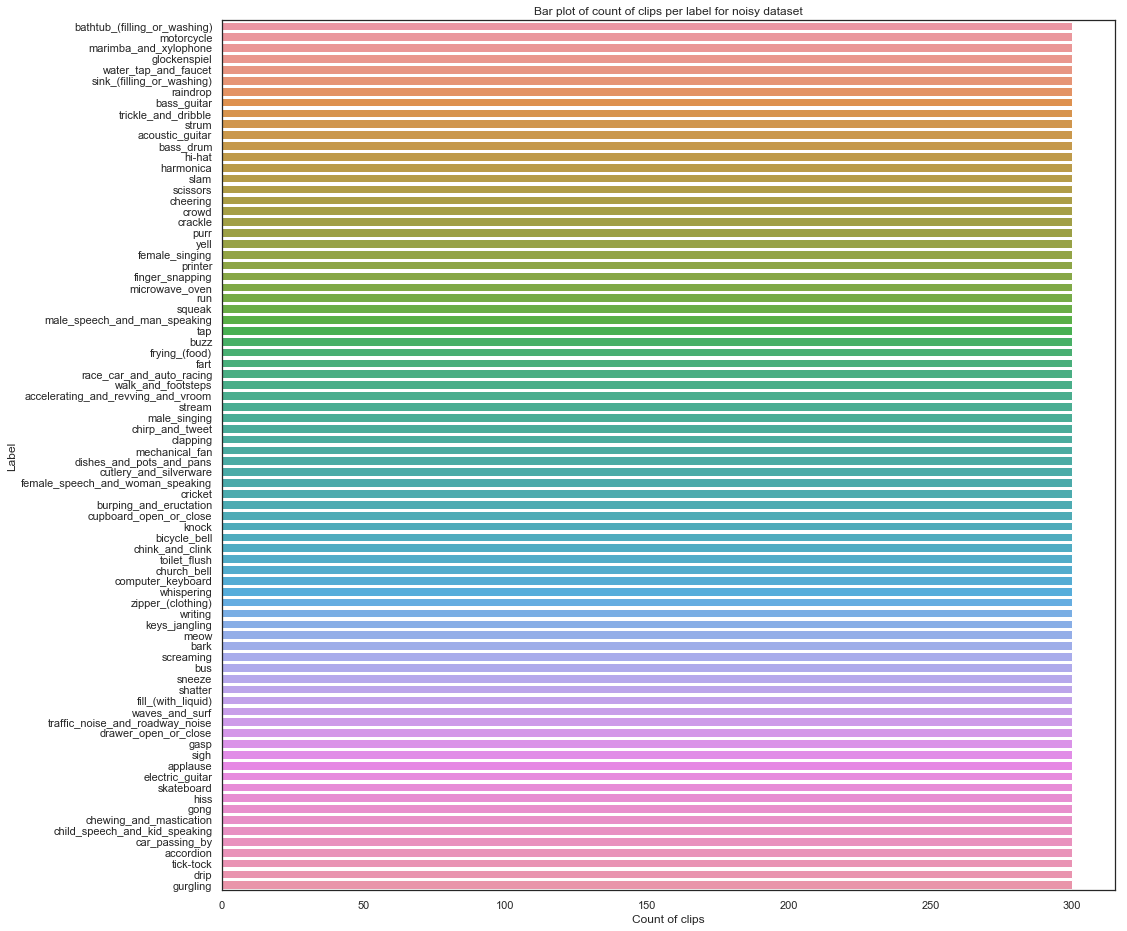

In [28]:
sns.barplot(x='Count', y='Label', data=df_noisy_label)
plt.title('Bar plot of count of clips per label for noisy dataset')
plt.xlabel('Count of clips')
plt.show()

### Conclusion
There are exactly equal number of clips for each label in the noisy dataset. This indicates the dataset is well balanced which will be useful in model building

## 2. Number of labels for each clip

### 2.1 Curated Dataset

In [29]:
curated_label_list = [label.split(',') for label in list(df_train_curated['labels'])]

In [30]:
number_labels_curated = {}
for row in curated_label_list:
    len_row = len(row)
    if len_row in number_labels_curated:
        number_labels_curated[len_row]+=1
    else:
        number_labels_curated[len_row]=1

In [34]:
#Sort dictionary by values: https://stackoverflow.com/a/2258273
number_labels_curated = sorted(number_labels_curated.items(), key=lambda x: x[1], reverse=True)
df_curated_count = pd.DataFrame(number_labels_curated, columns=["Number of labels", "Count"])
df_curated_count['Percentage composition'] = round(df_curated_count['Count']/df_curated_count['Count'].sum()*100, 2)
df_curated_count

,Number of labels,Count,Percentage composition
0,1,4269,85.90
1,2,627,12.62
2,3,69,1.39
3,4,4,0.08
4,6,1,0.02


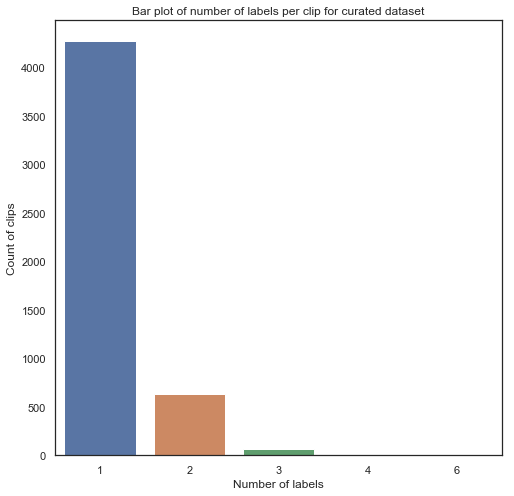

In [38]:
sns.barplot(x='Number of labels', y='Count', data=df_curated_count)
plt.ylabel('Count of clips')
plt.title('Bar plot of number of labels per clip for curated dataset')
plt.show()

### Conclusion
A majority of the clips have a single label and a few clips have 2 labels <br>

### 2.2 Noisy Dataset

In [39]:
noisy_label_list = [label.split(',') for label in list(df_train_noisy['labels'])]

In [40]:
number_labels_noisy = {}
for row in noisy_label_list:
    len_row = len(row)
    if len_row in number_labels_noisy:
        number_labels_noisy[len_row]+=1
    else:
        number_labels_noisy[len_row]=1

In [44]:
#Sort dictionary by values: https://stackoverflow.com/a/2258273
number_labels_noisy = sorted(number_labels_noisy.items(), key=lambda x: x[1], reverse=True)
df_noisy_count = pd.DataFrame(number_labels_noisy, columns=["Number of labels", "Count"])
df_noisy_count['Percentage composition'] = round(df_noisy_count['Count']/df_noisy_count['Count'].sum()*100, 2)
df_noisy_count

,Number of labels,Count,Percentage composition
0,1,16566,83.60
1,2,2558,12.91
2,3,504,2.54
3,4,141,0.71
4,5,38,0.19
5,6,4,0.02
6,7,4,0.02


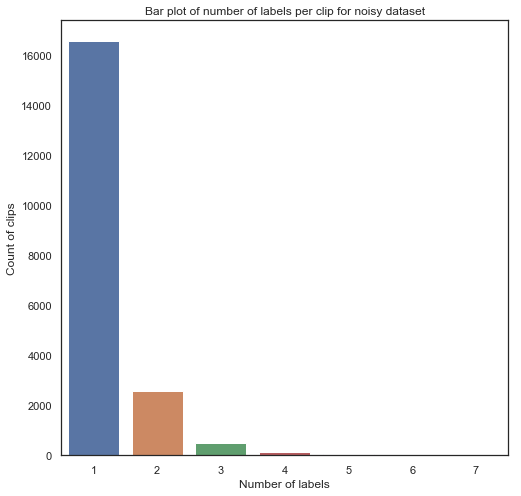

In [45]:
sns.barplot(x='Number of labels', y='Count', data=df_noisy_count)
plt.ylabel('Count of clips')
plt.title('Bar plot of number of labels per clip for noisy dataset')
plt.show()

### Conclusion
A majority of the clips (84%) have a single label and a few clips (13%) have 2 labels and a very few have 3 labels (2%). <br>
This encompasses 99% of the total clips. <br>
This distribution is almost the same for curated as well as noisy dataset.

## 3. Length of clips

### 3.1 Curated Dataset

In [48]:
def get_clip_duration(filename):
    '''
    This function takes input as the filename of .wav file, reads it and returns it's time duration/length (in seconds)
    Input  -> Filename (string)
    Output -> Time duration in seconds (float)
    '''
    wav = wave.open(r'../train_data_curated/' + filename)
    return wav.getnframes()/wav.getframerate()

In [50]:
df_train_curated['duration'] = df_train_curated['fname'].apply(get_clip_duration)

In [52]:
df_train_curated['duration'].describe()

count    4970.000000
mean        7.647674
std         7.696291
min         0.300000
25%         1.612205
50%         4.675918
75%        11.146372
max        57.571179
Name: duration, dtype: float64

### PDF of time durations for curated dataset

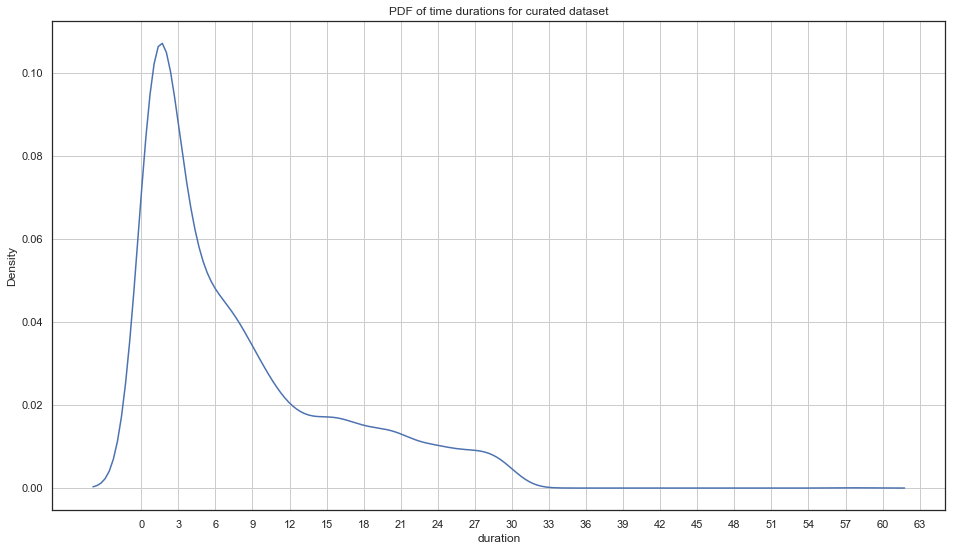

In [8]:
sns.kdeplot(df_train_curated['duration'])
plt.title('PDF of time durations for curated dataset')
plt.xticks(np.arange(0, 64, 3))
plt.grid()
plt.show()

### Conclusion
Audio clips from the curated dataset range from 0.3-30 seconds with a median length of 4.67 seconds. There is a lot of variance in the lengths of clips from the curated dataset.

### Label wise distribution of Audio Lengths

In [57]:
# Creating a list of all unique labels in the curated training dataset
all_labels_curated = set()
for row in df_train_curated['labels'].values:
    lab_list = row.split(',')
    for label in lab_list:
        all_labels_curated.add(label)
        
all_labels_curated = np.array(list(all_labels_curated))

In [101]:
# Choosing five random labels
five_random_labels = np.random.choice(all_labels_curated, size=5, replace=False)

In [103]:
df_five_random_labels = pd.DataFrame()
for idx, row in df_train_curated.iterrows():
    for label in five_random_labels:
        row_str = re.compile(str(row['labels']))
        if row_str.search(label):
            row['labels']=label
            df_five_random_labels = df_five_random_labels.append(row, ignore_index=True)
            break

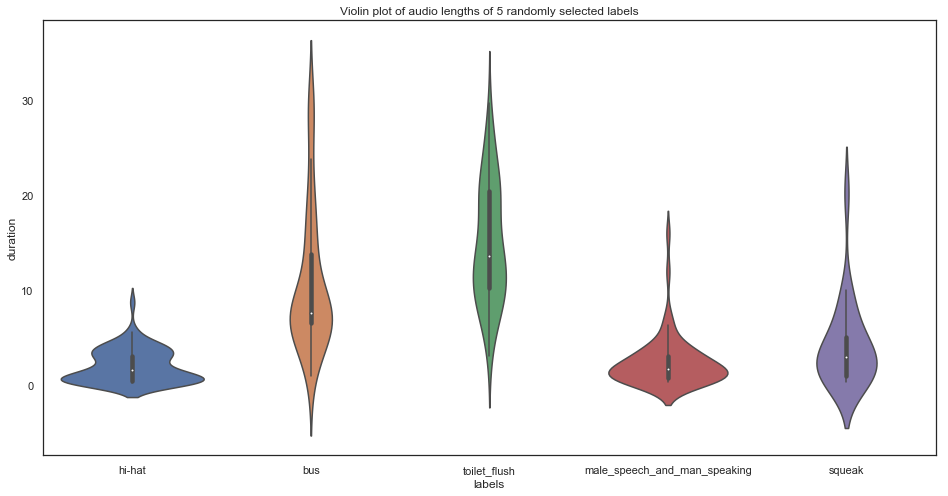

In [110]:
sns.violinplot(x='labels', y='duration', data=df_five_random_labels)
plt.title("Violin plot of audio lengths of 5 randomly selected labels")
plt.show()

### Conclusion
In the curated dataset, few labels (hi-hat) have very less variance in audio lengths, while few labels (bus) have high variance. <br> Overall, there are different variances across the labels in the curated dataset.

### 3.2 Noisy Dataset

In [130]:
def get_clip_duration(filename):
    '''
    This function takes input as the filename of .wav file, reads it and returns it's time duration/length (in seconds)
    Input  -> Filename (string)
    Output -> Time duration in seconds (float)
    '''
    wav = wave.open(r'../train_data_noisy/' + filename)
    return wav.getnframes()/wav.getframerate()

In [135]:
df_train_noisy['duration'] = df_train_noisy['fname'].apply(get_clip_duration)
df_train_noisy.to_csv('df_train_noisy_with_durations.csv', index=False)
df_train_noisy = pd.read_csv('../df_train_noisy_with_durations.csv')
df_train_noisy['duration'].describe()

count    19815.000000
mean        14.591555
std          1.623519
min          1.044898
25%         15.000000
50%         15.000000
75%         15.000000
max         15.998549
Name: duration, dtype: float64

### Histogram of time durations for noisy dataset

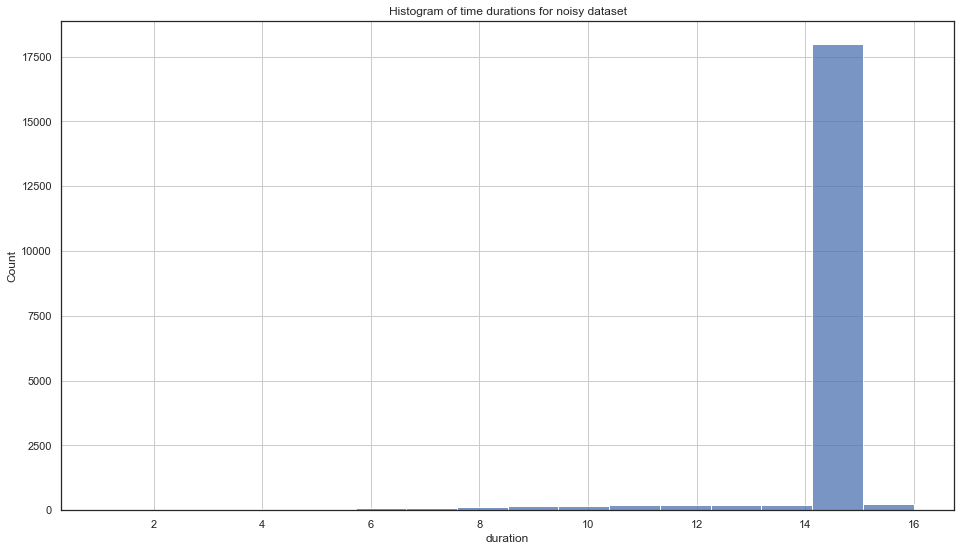

In [13]:
sns.histplot(df_train_noisy['duration'])
plt.title('Histogram of time durations for noisy dataset')
plt.grid()
plt.show()

In [17]:
print("Percentage of clips having 15 seconds length = ", np.round(df_train_noisy[df_train_noisy['duration'] == 15].shape[0]/df_train_noisy.shape[0]*100, 2), "%")

Percentage of clips having 15 seconds length =  89.67 %


### Conclusion

Audio clips from the noisy dataset range 1-16 seconds with a lot of clips (~90%) being close to 15 seconds in length. The variance here is much smaller than in the curated dataset.

### Label wise distribution of Audio Lengths

In [118]:
df_five_random_labels = pd.DataFrame()
for idx, row in df_train_noisy.iterrows():
    for label in five_random_labels:
        row_str = re.compile(str(row['labels']))
        if row_str.search(label):
            row['labels']=label
            df_five_random_labels = df_five_random_labels.append(row, ignore_index=True)
            break

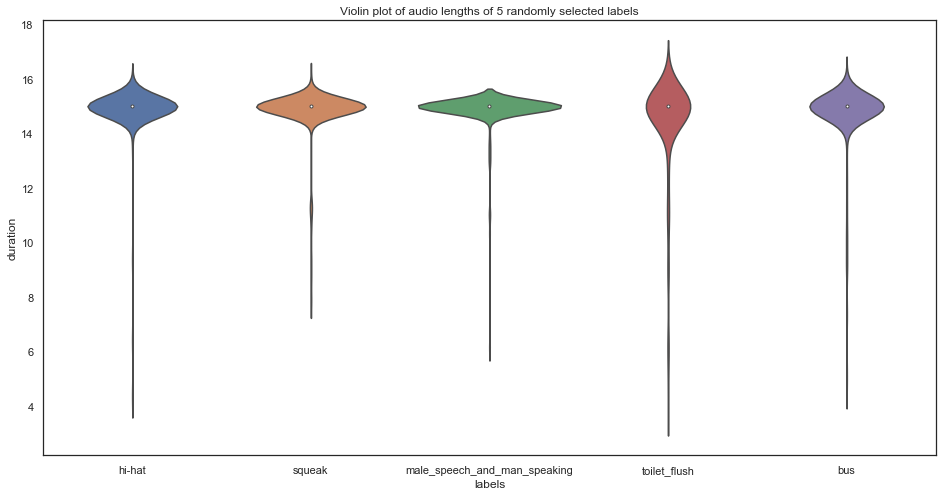

In [119]:
sns.violinplot(x='labels', y='duration', data=df_five_random_labels)
plt.title("Violin plot of audio lengths of 5 randomly selected labels")
plt.show()

### Conclusion
In the noisy dataset, most labels have a similar variance in audio lengths (this is in contrast with the curated dataset, where each label had a different variance). This is in concurrence with the observation that 90% audio clips are exactly 15 seconds long and hence a similar variance among different labels is expected.

## 4. Amplitude of clips

### 4.1 Curated Dataset

In [122]:
def get_peak_and_average_amplitudes(file_dir):
    '''
    This function returns the sorted list of peak and average amplitudes for all clips present in the "file_dir" directory
    Input ->
        file_dir: Parent directory containing the relevant .wav files
    Output ->
        A tuple of: (List of peak amplitudes, List of average amplitudes)
    '''
    files = os.listdir(file_dir)
    peak_amplitudes_curated = np.zeros(len(files))
    average_amplitudes_curated = np.zeros(len(files))
    
    for idx, file in enumerate(files):
        samplerate, data = scipy.io.wavfile.read(file_dir + file)
        abs_data = np.abs(data)
        peak_amplitudes_curated[idx] = np.max(abs_data)
        average_amplitudes_curated[idx] = np.mean(abs_data)
    
    peak_amplitudes_curated    = np.sort(peak_amplitudes_curated)
    average_amplitudes_curated = np.sort(average_amplitudes_curated)
    return (peak_amplitudes_curated, average_amplitudes_curated)

In [123]:
peak_amplitudes_curated, average_amplitudes_curated = get_peak_and_average_amplitudes(r'../train_data_curated/')

### 4.1.1 Peak Amplitude

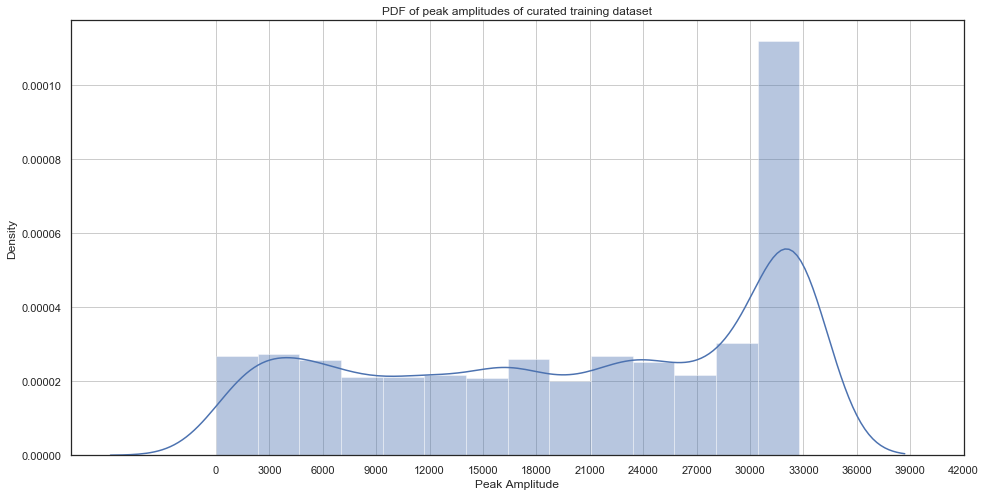

In [124]:
sns.distplot(peak_amplitudes_curated)
plt.grid()
plt.title('PDF of peak amplitudes of curated training dataset')
plt.xticks(np.arange(0,45000,3000))
plt.xlabel('Peak Amplitude')
plt.show()

### Conclusion
Most of the clips have a peak amplitude of 30,000

### 4.1.2 Average Amplitude

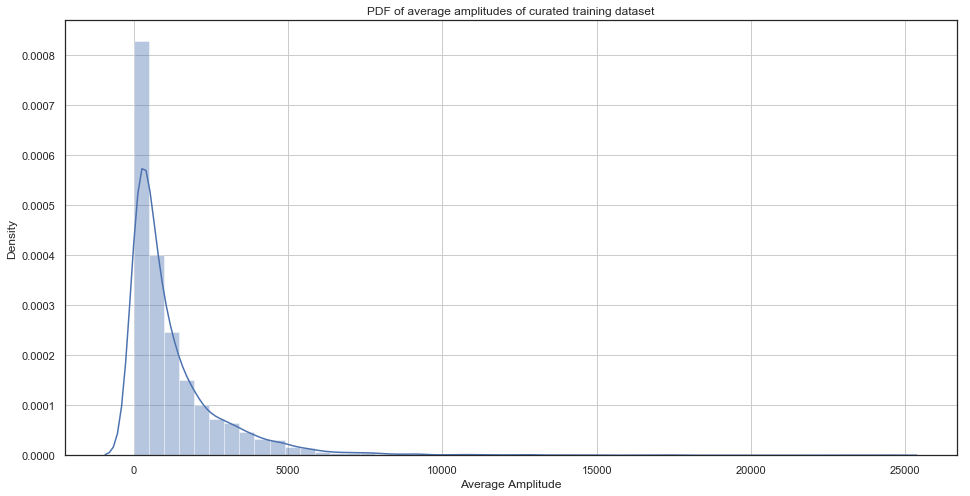

In [125]:
sns.distplot(average_amplitudes_curated)
plt.grid()
plt.title('PDF of average amplitudes of curated training dataset')
plt.xlabel('Average Amplitude')
plt.show()

### Conclusion
The average amplitude follows a distribution close to Power Law distriubtion. That is, most of the waves have the average amplitude close to 0 and the count reduces significantly and quickly for higher values of the average amplitude.

#### Since, the above dist. looks like a power law dist., we can apply box-cox transformation on it and then check (using Q-Q Plot) whether it gets transformed to a normal distribution or not

In [70]:
# This transformation is done because box-cox transformation does not accept inputs <= 0, so, we added a small value (delta)
# to all the zeroes to make the transformation viable
average_amplitudes_curated_transformed = [i+ 0.0001 if i==0 else i for i in average_amplitudes_curated]

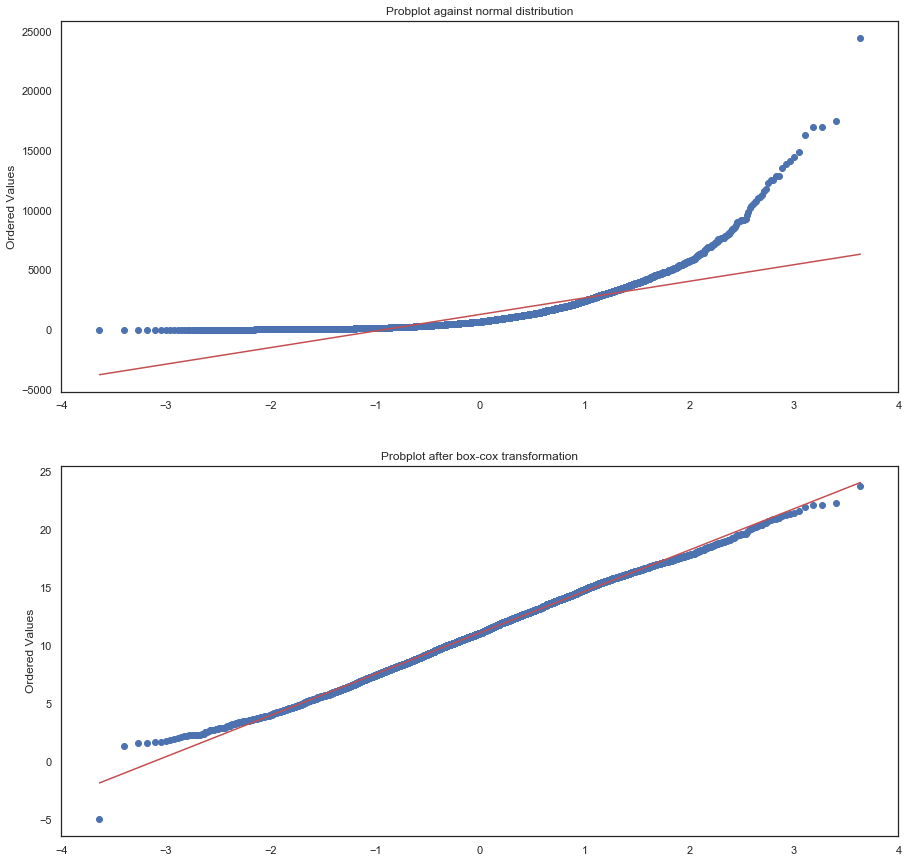

In [117]:
#Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(average_amplitudes_curated_transformed, dist=stats.norm, plot=ax1)
ax1.set_title('Probplot against normal distribution')
ax1.set_xlabel('')

ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(average_amplitudes_curated_transformed)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after box-cox transformation')
ax2.set_xlabel('')

plt.show()

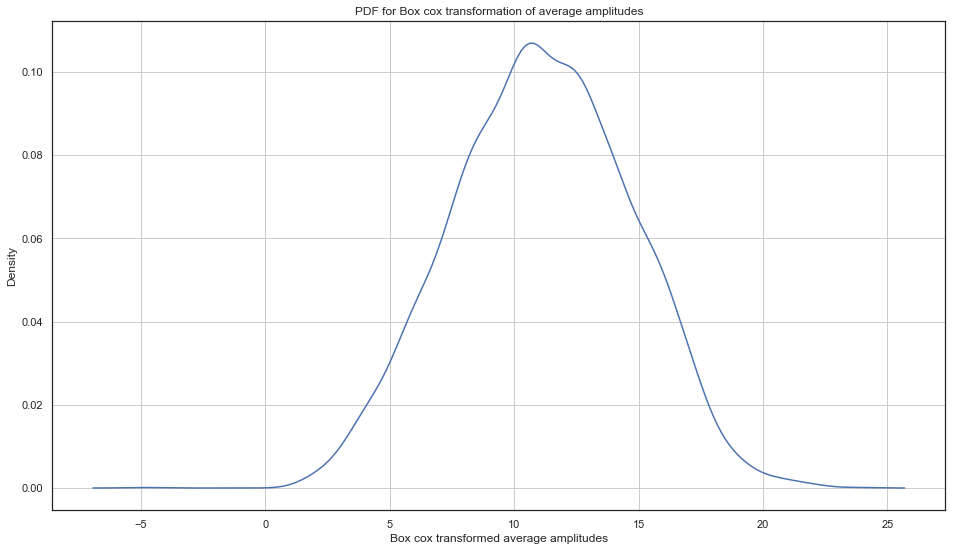

In [123]:
#Plotting PDF of box cox tranformed average amplitudes
sns.kdeplot(xt)
plt.title('PDF for Box cox transformation of average amplitudes')
plt.xlabel('Box cox transformed average amplitudes')
plt.grid()
plt.show()

#### The distribution looks close to a normal distribution from QQ Plot but there are some points which deviate majorly. So, we use KS Test to confirm our hypothesis.

In [118]:
np.random.seed(21)
stats.kstest(xt, 'norm')

KstestResult(statistic=0.9919721504540437, pvalue=0.0)

#### KS Test clearly indicates it's not a normal distribution, but, from the plots, it looks close to it

### 4.2 Noisy Dataset

In [56]:
peak_amplitudes_noisy, average_amplitudes_noisy = get_peak_and_average_amplitudes(r'../train_data_noisy/')

### 4.2.1 Peak Amplitude

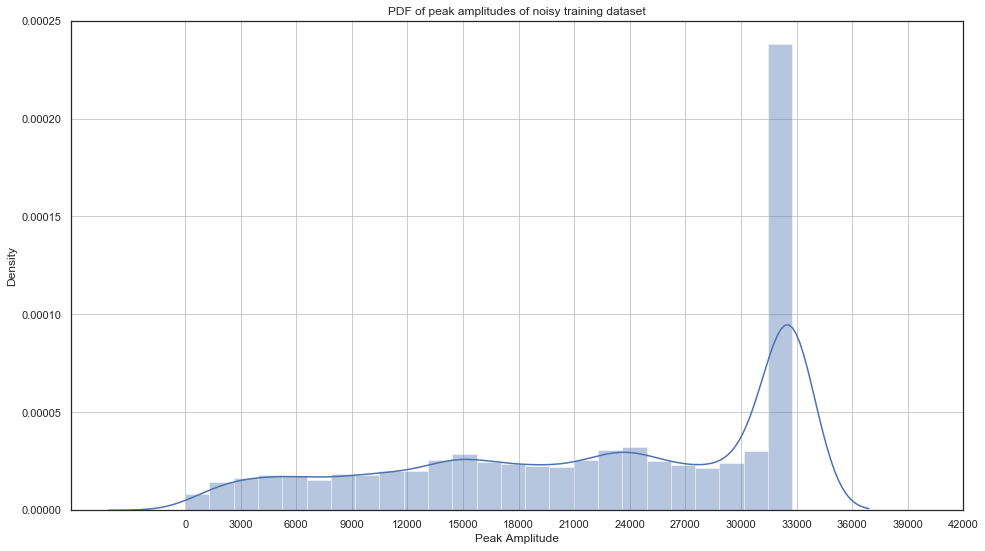

In [57]:
sns.distplot(peak_amplitudes_noisy)
plt.grid()
plt.title('PDF of peak amplitudes of noisy training dataset')
plt.xticks(np.arange(0,45000,3000))
plt.xlabel('Peak Amplitude')
plt.show()

### Conclusion
The peak amplitudes follow a similar dist. as that in the curated dataset, most of the clips have a peak amplitude of the maximum amplitude: 30,000

### 4.2.2 Average Amplitude

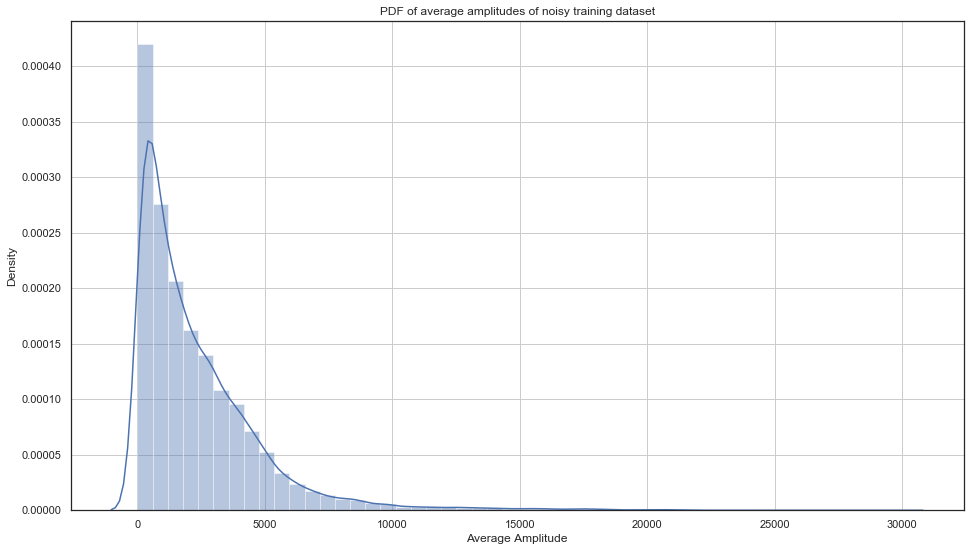

In [56]:
sns.distplot(average_amplitudes_noisy)
plt.grid()
plt.title('PDF of average amplitudes of noisy training dataset')
plt.xlabel('Average Amplitude')
plt.show()

### Conclusion
The average amplitude follows a distribution close to Power Law distriubtion. That is, most of the waves have the average amplitude close to 0 and the count reduces significantly and quickly for higher values of the average amplitude.

## 5. Peak frequency extracted from FFT of clips

### 5.1 Curated Dataset

In [57]:
def get_peak_frequency_fft(file_dir):
    '''
    This function returns the sorted list of peak frequency for all clips present in the "file_dir" directory
    Input ->
        file_dir: Parent directory containing the relevant .wav files
    Output ->
        List of peak frequencies extracted from FFT of all the clips present in the "file_dir" directory
    '''
    files = os.listdir(file_dir)
    peak_frequencies_curated = np.zeros(len(files))
    
    for idx, file in enumerate(files):
        samplerate, data = scipy.io.wavfile.read(file_dir + file)
        w = np.fft.fft(data)
        freqs = np.fft.fftfreq(len(w))
        idx = np.argmax(np.abs(w))
        freq = freqs[idx]
        freq_in_hertz = abs(freq * samplerate)
        peak_frequency_curated[idx] = freq_in_hertz
    
    peak_frequencies_curated = np.sort(peak_frequencies_curated)
    return peak_frequencies_curated

In [126]:
peak_frequencies_curated = get_peak_frequency_fft(r'../train_data_curated/')

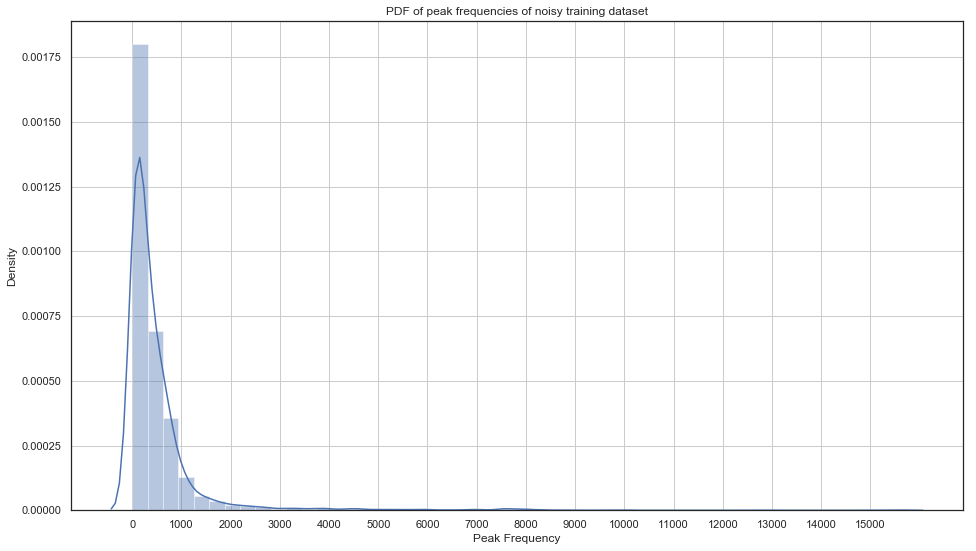

In [63]:
sns.distplot(peak_frequencies_curated)
plt.grid()
plt.title('PDF of peak frequencies of curated training dataset')
plt.xticks(np.arange(0, 16000, 1000))
plt.xlabel('Peak Frequency')
plt.show()

### Conclusion
The peak frequency follows a distribution close to Power Law distriubtion. That is, most of the waves have the peak frequency close to 0 and the count reduces significantly and quickly for higher values of the peak frequencies.

### 5.2 Noisy Dataset

In [127]:
peak_frequency_noisy = get_peak_frequency_fft(r'../train_data_noisy')

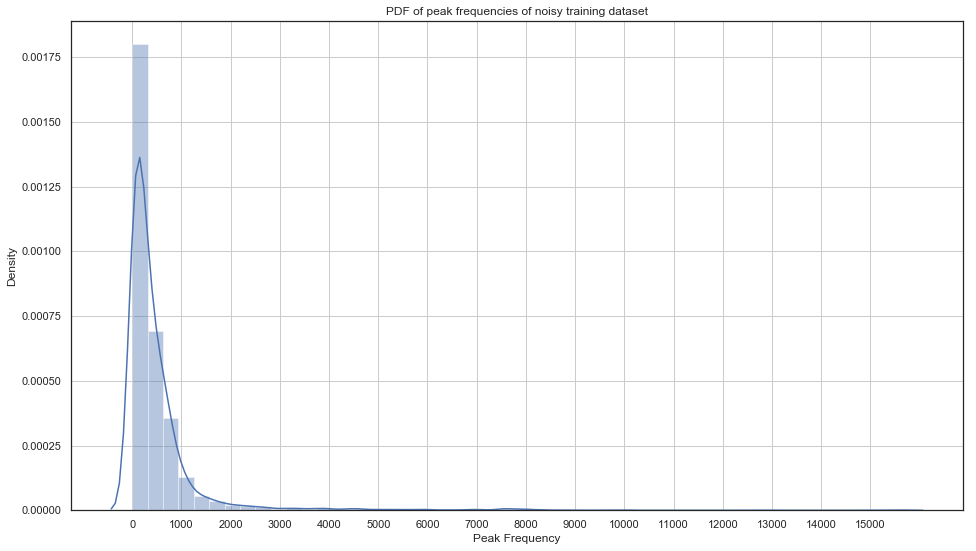

In [63]:
sns.distplot(peak_frequency_noisy)
plt.grid()
plt.title('PDF of peak frequencies of noisy training dataset')
plt.xticks(np.arange(0, 16000, 1000))
plt.xlabel('Peak Frequency')
plt.show()

### Conclusion
The average frequency also follows a distribution close to Power Law distriubtion. That is, most of the waves have the peak frequency close to 0 and the count reduces significantly and quickly for higher values of the peak frequencies. <br>
Here also, most frequencies are close to 0 and hence, the box cox transformation will not work properly, so we leave it this time.

## Insights from EDA:
1. We have roughly the same quantity of data per label, so the dataset can be considered as balanced. <br><br>
2. The curated dataset consists of clearly audible clips, but, we have only 60 clips per class for the curated dataset. On the other hand, the noisy dataset's clips contain a lot of background noise and are not clear, but, we have these in abundance, i.e., 250 per class. So, either we develop a model that can predict well with less data or we have to somehow clean the noisy data so that the labels become clearly distinguishable. <br><br>
3. Most of the clips contain only one label per clip, which is a good thing for our models. <br><br>
4. The majority of the clips in the curated dataset are short in length (<5 seconds), this can be challenging because predicting the type of sound from a very short clip (1–2 seconds) is difficult for a human also. While, in the noisy dataset, almost all clips are 15 seconds long, but, these contain a lot of background noise. <br><br>
5. Most of the clips have the same average amplitude which indicates nearly the same average loudness level for all the clips.